In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

C:\Users\User\miniconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read data

In [2]:
use_adjusted_et_data = True

data_et_uncorrected = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/uncorrected/data_et.csv')

data_et = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/adjusted/data_et.csv')
    
data_trial = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/adjusted/data_trial.csv')
data_subject = pd.read_csv(
    r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/adjusted/data_subject.csv')

print(pd.DataFrame([
    [
        len(data_et), 
        len(data_et['run_id'].unique())
    ], 
    [
        len(data_et_uncorrected), 
        len(data_et_uncorrected['run_id'].unique())
    ], 
    [
        len(data_trial),
        len(data_trial['run_id'].unique())
    ], 
    [
        len(data_subject), 
        len(data_subject['run_id'].unique())
    ]
], 
   columns=['length', 'run'],
   index=['data_et', 'data_et_uncorrected', 'data_trial', 'data_subject'])
)

                     length  run
data_et              303576  208
data_et_uncorrected  572780  208
data_trial            16596  208
data_subject            208  208


# Categorical confounders

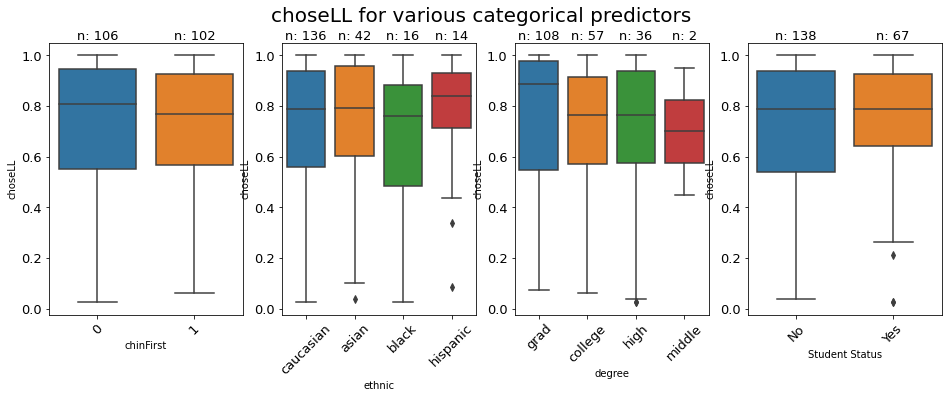

In [3]:
predictors = ['chinFirst', 'ethnic', 'degree', 'Student Status']  
outcome = 'choseLL'

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
plt.subplots_adjust(hspace=0.5)


ax = ax.ravel()

for i in range(0, 4):
    sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)

    ax[i].tick_params(labelrotation=45, labelsize=13)
    ax[i].tick_params(axis='y', labelrotation=None)

    nobs = data_subject[predictors[i]].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))

    max_value = data_subject[outcome].max()
    yPos = max_value + max_value * 0.1
    
    for tick,label in zip(pos,ax[i].get_xticklabels()):                
        ax[i].text(
            pos[tick], yPos, nobs[tick],
            verticalalignment='top',
            horizontalalignment='center', size=13, weight='normal')

# Visualize eye movements

## Individual

In [4]:
data_et_uncorrected.columns

Index(['run_id', 'trial_index', 'withinTaskIndex', 'x', 'y', 't_task',
       'amountLeft', 'LL_top', 'look_left', 'look_top', 'aoi', 'aoi_aLL',
       'aoi_tLL', 'aoi_aSS', 'aoi_tSS', 'fix_counter'],
      dtype='object')

In [5]:
data_plot = data_et_uncorrected.loc[
    data_et_uncorrected['run_id']==128, :]

def add_var_to_data_et(data_et, source_data, varName):
    
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    
    data_et = data_et.merge(
        source_data.loc[:,
            ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    
    return data_et

data_plot = add_var_to_data_et(data_plot, data_trial, 'trial_duration_exact')

105    21.062559
Name: fps, dtype: float64


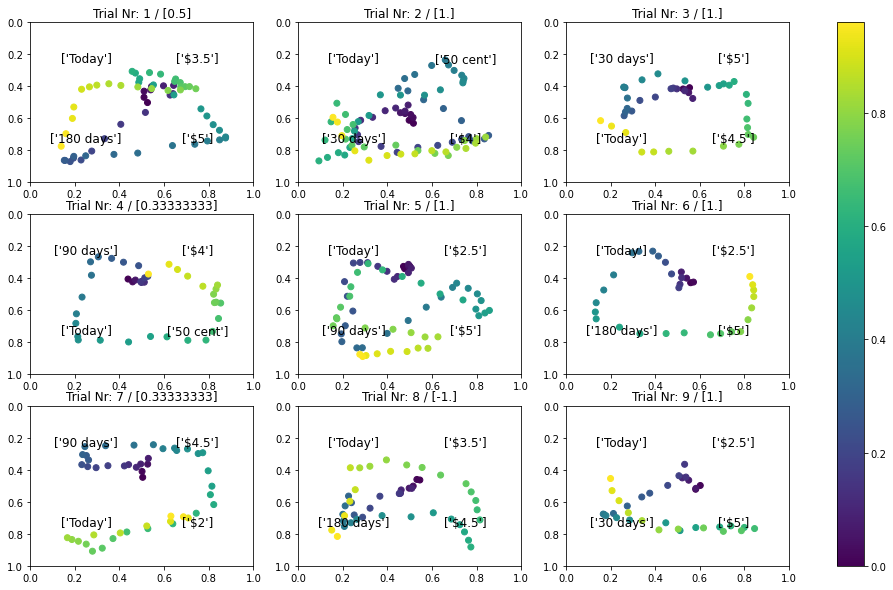

In [6]:
data_plot['t_task_rel'] = data_plot['t_task'] / data_plot['trial_duration_exact']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 10))
axes = axes.ravel()

thisSubject = data_plot['run_id'].unique()[0]
print(data_subject.loc[data_subject['run_id']==thisSubject, 'fps'])
for i in range(0, 9):
    
    df_thisTrial = data_trial.loc[
        (data_trial['run_id']==thisSubject) &
        (data_trial['withinTaskIndex']==50+i+1), :]
    
    payne = df_thisTrial['payneIndex'].values
    
    axes_data = data_plot.loc[data_plot['withinTaskIndex']==i+1, :]
    im = axes[i].scatter(axes_data['x'], axes_data['y'], c=axes_data['t_task_rel'], cmap='viridis')
    axes[i].set_title('Trial Nr: ' + str(i+1) + ' / ' + str(payne))
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
    # JS and python y coordinates seem to be inverted
    axes[i].text(0.25, 0.75, df_thisTrial['option_TL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.25, 0.25, df_thisTrial['option_BL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.75, df_thisTrial['option_TR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.25, df_thisTrial['option_BR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    
fig.colorbar(im, ax=axes)
plt.show()

105    21.062559
Name: fps, dtype: float64


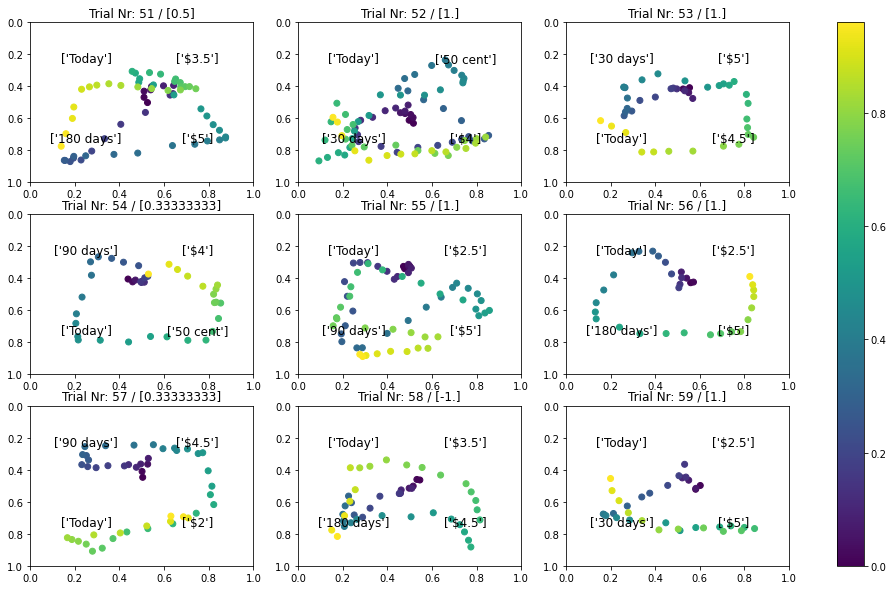

In [7]:
data_plot = data_et_uncorrected.loc[
    (data_et_uncorrected['run_id']==128), :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_plot = add_var_to_data_et(data_plot, data_trial, 'trial_duration_exact')
data_plot['t_task_rel'] = data_plot['t_task'] / data_plot['trial_duration_exact']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 10))
axes = axes.ravel()

thisSubject = data_plot['run_id'].unique()[0]
print(data_subject.loc[data_subject['run_id']==thisSubject, 'fps'])
for i in range(0, 9):
    
    df_thisTrial = data_trial.loc[
        (data_trial['run_id']==thisSubject) &
        (data_trial['withinTaskIndex']==50+i+1), :]
    
    payne = df_thisTrial['payneIndex'].values
    
    axes_data = data_plot.loc[data_plot['withinTaskIndex']==i+1, :]
    im = axes[i].scatter(axes_data['x'], axes_data['y'], c=axes_data['t_task_rel'], cmap='viridis')
    axes[i].set_title('Trial Nr: ' + str(50+i+1) + ' / ' + str(payne))
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
    # JS and python y coordinates seem to be inverted
    axes[i].text(0.25, 0.75, df_thisTrial['option_TL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.25, 0.25, df_thisTrial['option_BL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.75, df_thisTrial['option_TR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.25, df_thisTrial['option_BR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    
fig.colorbar(im, ax=axes)
plt.show()

In [8]:
data_trial.loc[
    (data_trial['run_id']==128) & 
    (data_trial['choseLL']==1) & 
    (
        (data_trial['option_TL']=='90 days') |
        (data_trial['option_TR']=='90 days') |
        (data_trial['option_BL']=='90 days') |
        (data_trial['option_BR']=='90 days')
    ), 
        [
        'run_id', 'withinTaskIndex', 
        'option_TL','option_BL', 'option_TR', 'option_BR', 'k', 
        'trial_duration_exact', 'x_count', 'fps', 
        'choseTop', 'choseLL', 

        'optionIndex', 'attributeIndex', 'payneIndex']
]

,run_id,withinTaskIndex,option_TL,option_BL,option_TR,option_BR,k,trial_duration_exact,x_count,fps,choseTop,choseLL,optionIndex,attributeIndex,payneIndex
245,128,7.0,$5,50 cent,90 days,Today,0.100000,2183,47.0,21.530005,1,1,-0.166667,-1.000000,0.333333
248,128,10.0,$4,50 cent,90 days,Today,0.077778,1631,35.0,21.459227,1,1,-0.500000,1.000000,1.000000
254,128,16.0,$1,$4.5,Today,90 days,0.038889,1211,27.0,22.295623,0,1,0.272727,1.000000,-0.333333
260,128,22.0,$5,$3,90 days,Today,0.007407,1625,32.0,19.692308,1,1,-0.333333,-0.333333,0.333333
261,128,23.0,$4.5,$3.5,90 days,Today,0.003175,1415,32.0,22.614841,1,1,-1.000000,-0.125000,0.333333
267,128,29.0,$1.5,$4,Today,90 days,0.018519,1324,30.0,22.658610,0,1,0.500000,0.500000,0.000000
274,128,36.0,$1,$5,Today,90 days,0.044444,1139,25.0,21.949078,0,1,0.250000,0.250000,-0.333333
288,128,50.0,90 days,Today,$4,$1.5,0.018519,1559,35.0,22.450289,1,1,0.000000,-0.625000,1.000000
292,128,54.0,90 days,Today,$4,50 cent,0.077778,1272,25.0,19.654088,1,1,1.000000,-0.090909,0.333333
293,128,55.0,Today,90 days,$2.5,$5,0.011111,1717,39.0,22.714036,0,1,0.428571,0.571429,1.000000


In [9]:
data_trial.loc[
    ((data_trial['run_id']==43) & 
    (data_trial['withinTaskIndex']==7)) |
    ((data_trial['run_id']==128) & 
    (data_trial['withinTaskIndex']==59)), 
    [
        'run_id', 'withinTaskIndex', 
        'option_TL','option_BL', 'option_TR', 'option_BR', 'k', 
        'trial_duration_exact', 'x_count', 'fps', 
        'choseTop', 'choseLL', 

        'optionIndex', 'attributeIndex', 'payneIndex']
]

,run_id,withinTaskIndex,option_TL,option_BL,option_TR,option_BR,k,trial_duration_exact,x_count,fps,choseTop,choseLL,optionIndex,attributeIndex,payneIndex
297,128,59.0,Today,30 days,$2.5,$5,0.033333,1406,31.0,22.048364,0,1,-1.000000,1.000000,1.0
13966,43,7.0,Today,90 days,$4,$5,0.002778,2319,82.0,35.360069,1,0,0.098039,-0.058824,1.0


## Heatmap

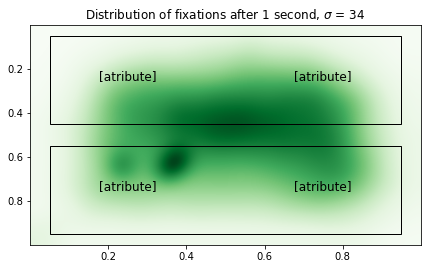

<Figure size 432x288 with 0 Axes>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


x = data_et_uncorrected.loc[data_et_uncorrected['t_task']>1000, 'x']
y = data_et_uncorrected.loc[data_et_uncorrected['t_task']>1000, 'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent



# Create figure and axes
fig,ax = plt.subplots(figsize=(7, 7))

s=34
img, extent = myplot(x, y, s=s)
ax.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))

rect = patches.Rectangle((0.05,0.05),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((0.05,0.55),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)

xPos = [0.25, 0.75, 0.25, 0.75]
yPos = [0.25, 0.25, 0.75, 0.75]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '[atribute]', size=12, ha="center")

ax.set_title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)

plt.show()
plt.savefig('plots/choice_heatmap.png')

# Correlations

## Subject-level

### Clean data

In [11]:
def clean_data(data):
    
    output_data = data.copy()
    
    null_data = output_data.loc[output_data.isnull().any(axis=1), :]

    show_null_data = null_data  \
        .groupby(['run_id'], as_index=False).count() \
        .iloc[:, :2] 
    show_null_data.columns=['run_id', 'n']
    
    if len(null_data)>0:
        print('! Attention ! Missing values \n')
        print(
            f"""Length of data raw: {len(output_data)} | """
            f"""Unique runs: {len(output_data['run_id'].unique())}"""

        )
    else: 
        print('No missing data found')

    output_data = output_data.loc[~output_data.isnull().any(axis=1), :]

    print(
            f"""Length of data clean: {len(output_data)} | """ 
            f"""Unique runs: {len(data_plot['run_id'].unique())} \n \n"""
            f"""Excluded runs and trials: \n"""
            f"""{show_null_data} \n"""
    )
    return output_data

data_plot = clean_data(
    data_subject.loc[
        :,
        [
            'run_id', 'chinFirst', 'age', 'choseLL', 
            'attributeIndex', 'optionIndex', 'payneIndex', 
            'choice_rt'
        ]
    ]
)

! Attention ! Missing values 

Length of data raw: 208 | Unique runs: 208
Length of data clean: 204 | Unique runs: 1 
 
Excluded runs and trials: 
   run_id  n
0     171  1
1     243  1
2     425  1
3     436  1 



### Plot

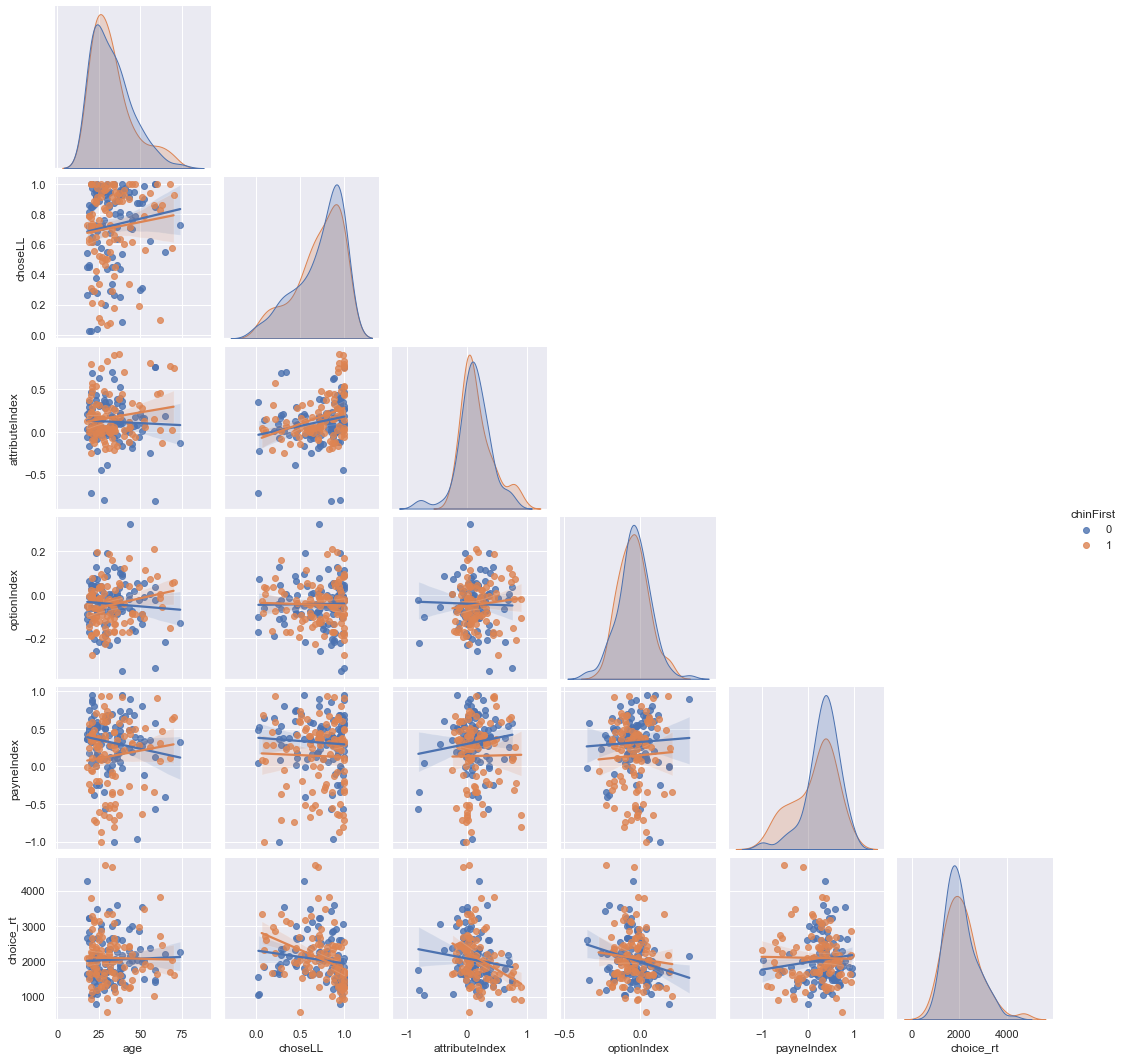

In [12]:
sns.set()
sns.pairplot(
    data_plot.loc[
        :,     
        [
            'chinFirst', 'age', 'choseLL', 
            'attributeIndex', 'optionIndex', 'payneIndex', 
            'choice_rt'
        ]
    ], 
    kind='reg', 
    corner=True,
    hue='chinFirst'
)

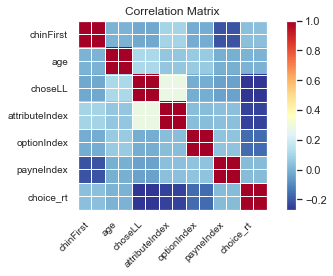

In [13]:
corr_columns = [
        'chinFirst', 'age', 'choseLL', 
        'attributeIndex', 'optionIndex', 'payneIndex', 
        'choice_rt'
    ]

corr_matrix = np.corrcoef(data_plot.loc[:, corr_columns].T)

corr_table_p = data_plot[corr_columns].rcorr()
corr_table_n = data_plot[corr_columns].rcorr(upper='n')

smg.plot_corr(corr_matrix, xnames=corr_columns)
plt.show()

## trial-level

### Clean data

In [14]:
data_plot = clean_data(
    data_trial.loc[
        :,                  
        [
            'run_id', 'chinFirst', 'choseLL', 'k',
            'attributeIndex', 'optionIndex', 'payneIndex', 'trial_duration_exact'
        ]
    ]
)

! Attention ! Missing values 

Length of data raw: 16596 | Unique runs: 208
Length of data clean: 12331 | Unique runs: 204 
 
Excluded runs and trials: 
     run_id   n
0         4  18
1         5  27
2         6  14
3         7   1
4        11   2
..      ...  ..
186     449  22
187     454   5
188     456  35
189     458  37
190     462   5

[191 rows x 2 columns] 



### Plot

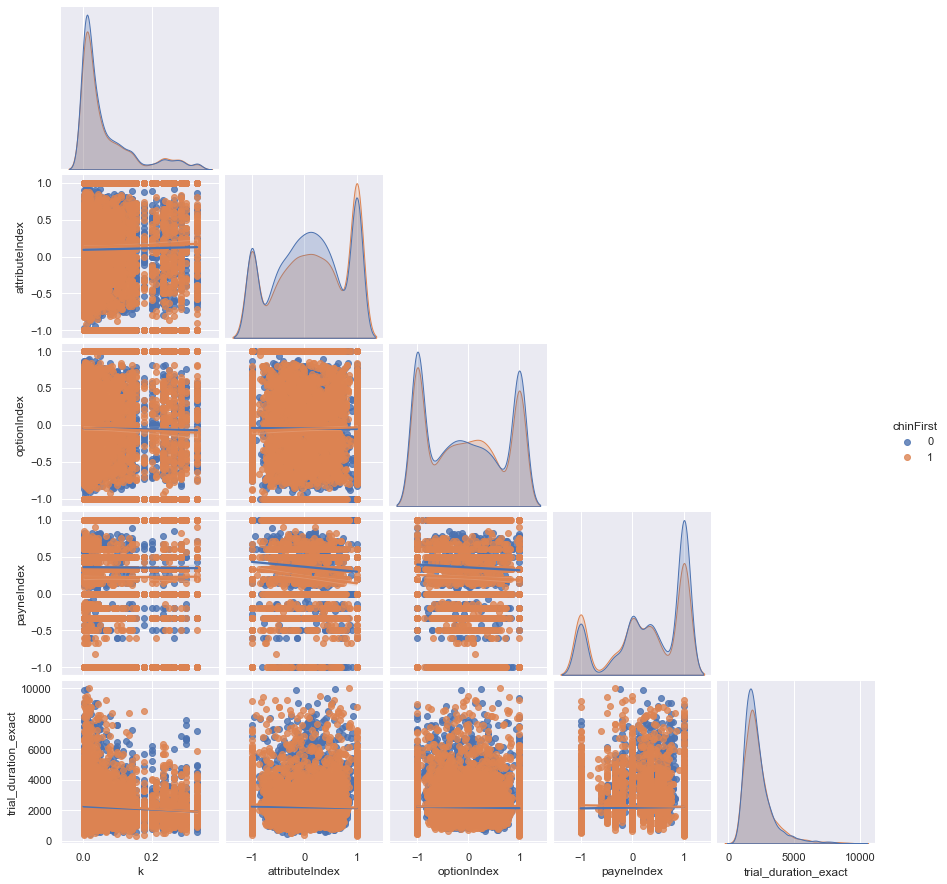

In [15]:
sns.pairplot(
    data_plot.loc[
        :,         
        [
            'chinFirst', 'k',
            'attributeIndex', 'optionIndex', 'payneIndex', 'trial_duration_exact'
        ]
    ], 
    kind='reg', 
    corner=True,
    hue='chinFirst'
)

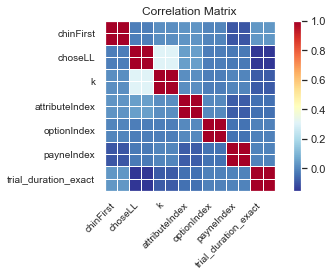

In [16]:
corr_columns = [
            'chinFirst', 'choseLL', 'k',
            'attributeIndex', 'optionIndex', 'payneIndex', 'trial_duration_exact'
        ]

corr_matrix = np.corrcoef(data_plot.loc[:, corr_columns].T)

corr_table_p = data_plot[corr_columns].rcorr()
corr_table_n = data_plot[corr_columns].rcorr(upper='n')

smg.plot_corr(corr_matrix, xnames=corr_columns)
plt.show()

In [17]:
corr_table_p

,chinFirst,choseLL,k,attributeIndex,optionIndex,payneIndex,trial_duration_exact
chinFirst,-,,,**,,***,***
choseLL,-0.016,-,***,***,,**,***
k,0.017,0.309,-,,,,***
attributeIndex,0.029,0.052,0.015,-,,***,***
optionIndex,-0.002,-0.017,-0.015,0.007,-,***,
payneIndex,-0.093,-0.026,-0.003,-0.079,-0.038,-,
trial_duration_exact,0.034,-0.153,-0.083,-0.045,-0.01,-0.005,-


In [18]:
corr_table_n

,chinFirst,choseLL,k,attributeIndex,optionIndex,payneIndex,trial_duration_exact
chinFirst,-,12331,12331,12331,12331,12331,12331
choseLL,-0.016,-,12331,12331,12331,12331,12331
k,0.017,0.309,-,12331,12331,12331,12331
attributeIndex,0.029,0.052,0.015,-,12331,12331,12331
optionIndex,-0.002,-0.017,-0.015,0.007,-,12331,12331
payneIndex,-0.093,-0.026,-0.003,-0.079,-0.038,-,12331
trial_duration_exact,0.034,-0.153,-0.083,-0.045,-0.01,-0.005,-
